In [ ]:
#############################################################################
############################# Assignment 2 ##################################
######################### Author: Shawn Liu #################################
#############################################################################

In [ ]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.7.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.7.0


In [ ]:
#mount to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/458_AI/Assignment2/'

In [ ]:
# define functions for model performance evaluation
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

#**Loading data & EDA**

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [ ]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


In [ ]:
#review labels and distribution of sample
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


<BarContainer object of 10 artists>

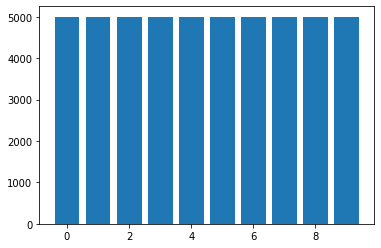

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)

frequency_trn = np.array((unique, counts))
plt.bar(frequency_trn[0], frequency_trn[1])

In [ ]:
#plot some examples

def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [ ]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [ ]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

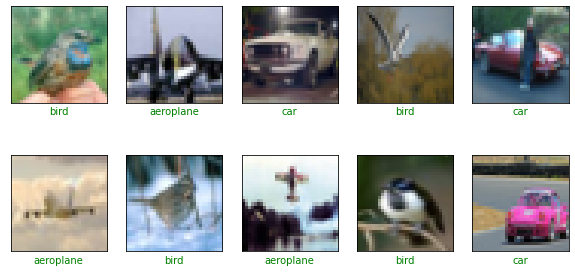

In [ ]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

#**Preprocessing Data For Model Development**

In [ ]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

In [ ]:
##create validation Dataset

x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [ ]:
#check dataset size and dimension, 10% of training data is hold out for validation purpose
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


In [ ]:
#scale normalize the data
#The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
# 1. Each element in each example is a pixel value
# 2. Pixel values range from 0 to 255
# 3. 0 = black
# 4. 255 = white

In [ ]:
x_train_norm = x_train_split / 255 
x_valid_norm = x_valid_split / 255
x_test_norm = x_test / 255

In [ ]:
#reshape the image for DNN training
width = 32
height = 32
channel = 3

x_train_flat = np.reshape(x_train_norm, (45000, width*height*channel))
x_valid_flat = np.reshape(x_valid_norm, (5000, width*height*channel))
x_test_flat = np.reshape(x_test_norm, (10000, width*height*channel))

In [ ]:
print(x_train_flat.shape, x_valid_flat.shape, x_test_flat.shape)

(45000, 3072) (5000, 3072) (10000, 3072)


In [ ]:
##initiate list to track performance for each model


train_accuracy = []
val_accuracy = []
test_accuracy = []
recall = []
f1 = []
precision = []
train_time = []

In [ ]:
# define function for turning softmax result to class category
def class_output(result):
  pred_list = []
  for i in range(len(result)):
    pred = np.argmax(result[i])
    pred_list.append(pred)
  return np.array(pred_list).reshape((len(result), 1))

In [ ]:
# define evaluation metrics tracking function

def score_track(model, x_train, y_train, x_val, y_val, x_test, y_test):
  result_dic = {}

  pred_trn = class_output(model.predict(x_train))
  ac_trn = accuracy_score(y_train, pred_trn)
  result_dic['accuracy_train'] = ac_trn

  pred_val = class_output(model.predict(x_val))
  ac_val = accuracy_score(y_val, pred_val)
  result_dic['accuracy_valid'] = ac_val

  pred_test = class_output(model.predict(x_test))
  ac_test = accuracy_score(y_test, pred_test)
  result_dic['accuracy_test'] = ac_test
  f1_test = f1_score(y_test, pred_test, average = 'macro')
  result_dic['f1_test'] = f1_test
  recall_test = recall_score(y_test, pred_test, average = 'macro')
  result_dic['recall_test'] = recall_test
  precision_test = precision_score(y_test, pred_test, average = 'macro')
  result_dic['precision_test'] = precision_test
  
  return result_dic

#**Experiment 1 - DNN with 2 layers (no regularization)**

1. two Dense Layer
2. no regularization

In [ ]:
model_1 = models.Sequential()
model_1.add(layers.Dense(input_shape = [width*height*channel], units=384, activation=tf.nn.relu))
model_1.add(layers.Dense(name = 'output_layer', units=10, activation=tf.nn.softmax))

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 384)               1180032   
                                                                 
 output_layer (Dense)        (None, 10)                3850      
                                                                 
Total params: 1,183,882
Trainable params: 1,183,882
Non-trainable params: 0
_________________________________________________________________


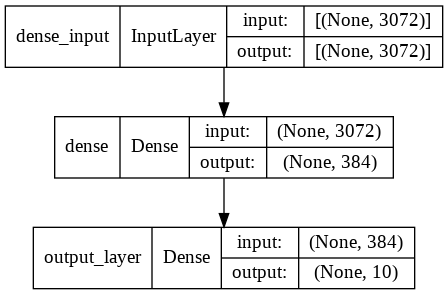

In [ ]:
keras.utils.plot_model(model_1, "cifar10_model1.png", show_shapes=True) 

In [ ]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #set from_logits = False since Softmax has been applied in output layer
              metrics=['accuracy'])

In [ ]:
start_time = time.time()

history_1 = model_1.fit(
    x_train_flat,
    y_train_split,
    batch_size = 512,
    epochs = 100, 
    validation_data=(x_valid_flat, y_valid_split),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
               tf.keras.callbacks.ModelCheckpoint(path +'model_{val_accuracy:.4f}.h5', save_best_only=True,save_weights_only=False, monitor='val_accuracy')]
)    


end_time = time.time()

Epoch 1/100
88/88 [==============================] - 3s 16ms/step - loss: 2.2997 - accuracy: 0.2475 - val_loss: 1.9172 - val_accuracy: 0.3260
Epoch 2/100
88/88 [==============================] - 1s 6ms/step - loss: 1.8669 - accuracy: 0.3406 - val_loss: 1.8396 - val_accuracy: 0.3444
Epoch 3/100
88/88 [==============================] - 1s 6ms/step - loss: 1.8058 - accuracy: 0.3631 - val_loss: 1.7922 - val_accuracy: 0.3688
Epoch 4/100
88/88 [==============================] - 1s 6ms/step - loss: 1.7517 - accuracy: 0.3840 - val_loss: 1.7571 - val_accuracy: 0.3792
Epoch 5/100
88/88 [==============================] - 1s 6ms/step - loss: 1.7143 - accuracy: 0.3966 - val_loss: 1.7377 - val_accuracy: 0.3820
Epoch 6/100
88/88 [==============================] - 1s 6ms/step - loss: 1.6781 - accuracy: 0.4085 - val_loss: 1.7093 - val_accuracy: 0.3830
Epoch 7/100
88/88 [==============================] - 1s 6ms/step - loss: 1.6473 - accuracy: 0.4203 - val_loss: 1.6906 - val_accuracy: 0.3978
Epoch 8/100


In [ ]:
#tracking training time
train_time = end_time - start_time

In [ ]:
#model evaluation

loss, accuracy = model_1.evaluate(x_test_flat, y_test)
print('test set accuracy: ', accuracy * 100)

test_accuracy.append(accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 1.4864 - accuracy: 0.4744
test set accuracy:  47.440001368522644


In [ ]:
model_1_score = score_track(model_1, x_train_flat, y_train_split, x_valid_flat, y_valid_split, x_test_flat, y_test)

In [ ]:
model_1_score

{'accuracy_test': 0.4744,
 'accuracy_train': 0.513,
 'accuracy_valid': 0.4586,
 'f1_test': 0.46135065489663135,
 'precision_test': 0.48672456103800454,
 'recall_test': 0.47440000000000004}

In [ ]:
model_1_score['train_time'] = train_time

In [ ]:
#make prediction

preds = model_1.predict(x_test_flat)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


In [ ]:
history_dict = history_1.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
26,1.410,0.505,1.523,0.453
27,1.385,0.516,1.505,0.467
28,1.380,0.516,1.509,0.462
29,1.380,0.516,1.504,0.463
30,1.373,0.518,1.509,0.459


In [ ]:
losses = history_1.history['loss']
accs = history_1.history['accuracy']
val_losses = history_1.history['val_loss']
val_accs = history_1.history['val_accuracy']
epochs = len(losses)

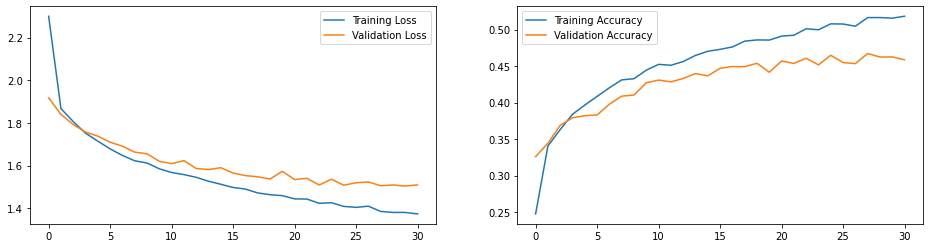

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
#confusion matrix generation

pred1= model_1.predict(x_test_flat)
pred1=np.argmax(pred1, axis=1)

In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.67      0.39      0.50      1000
           1       0.66      0.47      0.55      1000
           2       0.42      0.23      0.30      1000
           3       0.40      0.23      0.29      1000
           4       0.43      0.40      0.41      1000
           5       0.41      0.38      0.39      1000
           6       0.42      0.71      0.53      1000
           7       0.52      0.53      0.53      1000
           8       0.50      0.73      0.60      1000
           9       0.43      0.67      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.49      0.47      0.46     10000
weighted avg       0.49      0.47      0.46     10000

Accuracy Score: 0.4744
Root Mean Square Error: 3.260766780988791


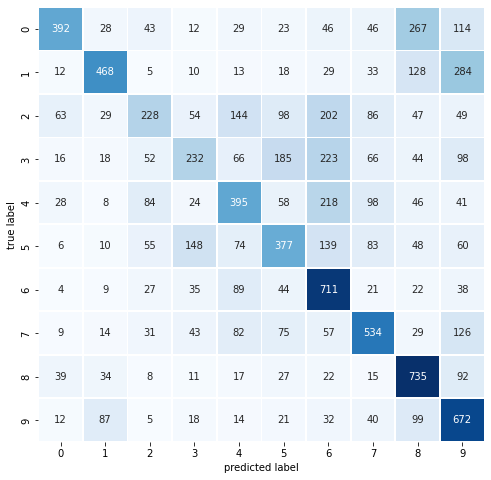

In [ ]:
plot_confusion_matrix(y_test,pred1)

#**Experiment 2 - DNN with 3 layers (no regularization)**

1. three Dense Layer
2. no regularization

In [ ]:
model_2 = models.Sequential()
model_2.add(layers.Dense(input_shape = [width*height*channel], units=384, activation=tf.nn.relu))
model_2.add(layers.Dense(input_shape = [384], units=128, activation=tf.nn.relu))
model_2.add(layers.Dense(name = 'output_layer', units=10, activation=tf.nn.softmax))

In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 384)               1180032   
                                                                 
 dense_2 (Dense)             (None, 128)               49280     
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 1,230,602
Trainable params: 1,230,602
Non-trainable params: 0
_________________________________________________________________


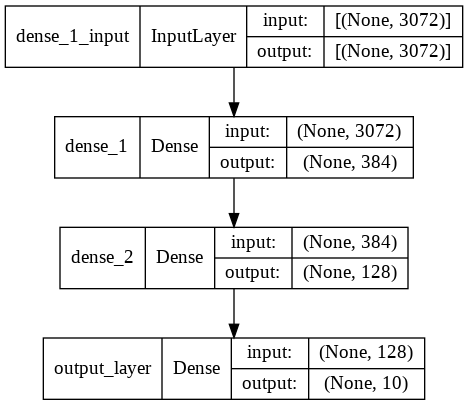

In [ ]:
keras.utils.plot_model(model_2, "cifar10_model1.png", show_shapes=True) 

In [ ]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #set from_logits = False since Softmax has been applied in output layer
              metrics=['accuracy'])

In [ ]:
start_time = time.time()

history_2 = model_2.fit(
    x_train_flat,
    y_train_split,
    batch_size = 512,
    epochs = 100, 
    validation_data=(x_valid_flat, y_valid_split),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
               tf.keras.callbacks.ModelCheckpoint(path +'model_{val_accuracy:.4f}.h5', save_best_only=True,save_weights_only=False, monitor='val_accuracy')]
)

end_time = time.time()

Epoch 1/100
88/88 [==============================] - 1s 8ms/step - loss: 2.0646 - accuracy: 0.2673 - val_loss: 1.8846 - val_accuracy: 0.3362
Epoch 2/100
88/88 [==============================] - 1s 7ms/step - loss: 1.8286 - accuracy: 0.3504 - val_loss: 1.7908 - val_accuracy: 0.3532
Epoch 3/100
88/88 [==============================] - 1s 6ms/step - loss: 1.7443 - accuracy: 0.3817 - val_loss: 1.7463 - val_accuracy: 0.3798
Epoch 4/100
88/88 [==============================] - 1s 7ms/step - loss: 1.6911 - accuracy: 0.4014 - val_loss: 1.7186 - val_accuracy: 0.3842
Epoch 5/100
88/88 [==============================] - 1s 7ms/step - loss: 1.6431 - accuracy: 0.4199 - val_loss: 1.6642 - val_accuracy: 0.4016
Epoch 6/100
88/88 [==============================] - 1s 6ms/step - loss: 1.6111 - accuracy: 0.4318 - val_loss: 1.6547 - val_accuracy: 0.4090
Epoch 7/100
88/88 [==============================] - 1s 7ms/step - loss: 1.5812 - accuracy: 0.4403 - val_loss: 1.6178 - val_accuracy: 0.4170
Epoch 8/100
8

In [ ]:
#tracking training time
train_time = end_time - start_time

In [ ]:
#model evaluation

loss, accuracy = model_2.evaluate(x_test_flat, y_test)
print('test set accuracy: ', accuracy * 100)

test_accuracy.append(accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 1.5041 - accuracy: 0.4622
test set accuracy:  46.219998598098755


In [ ]:
model_2_score = score_track(model_2, x_train_flat, y_train_split, x_valid_flat, y_valid_split, x_test_flat, y_test)

In [ ]:
model_2_score

{'accuracy_test': 0.4622,
 'accuracy_train': 0.488,
 'accuracy_valid': 0.45,
 'f1_test': 0.4497452202041881,
 'precision_test': 0.4764222456118736,
 'recall_test': 0.4622}

In [ ]:
model_2_score['train_time'] = train_time

In [ ]:
#make prediction

preds = model_2.predict(x_test_flat)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


In [ ]:
history_dict = history_2.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
8,1.532,0.457,1.569,0.438
9,1.496,0.473,1.529,0.459
10,1.472,0.481,1.517,0.458
11,1.456,0.486,1.510,0.459
12,1.433,0.494,1.526,0.450


In [ ]:
losses = history_2.history['loss']
accs = history_2.history['accuracy']
val_losses = history_2.history['val_loss']
val_accs = history_2.history['val_accuracy']
epochs = len(losses)

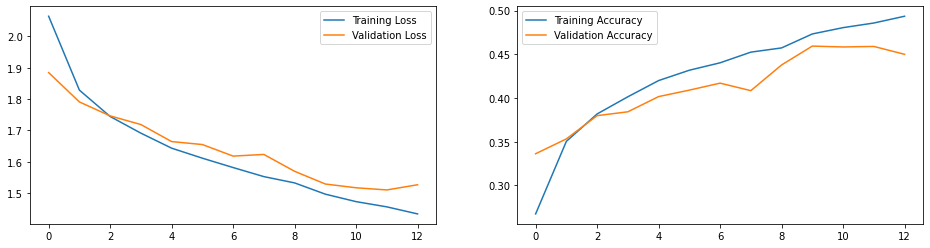

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
#confusion matrix generation

pred2= model_2.predict(x_test_flat)
pred2=np.argmax(pred2, axis=1)

In [ ]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.67      0.39      0.50      1000
           1       0.66      0.47      0.55      1000
           2       0.42      0.23      0.30      1000
           3       0.40      0.23      0.29      1000
           4       0.43      0.40      0.41      1000
           5       0.41      0.38      0.39      1000
           6       0.42      0.71      0.53      1000
           7       0.52      0.53      0.53      1000
           8       0.50      0.73      0.60      1000
           9       0.43      0.67      0.52      1000

    accuracy                           0.47     10000
   macro avg       0.49      0.47      0.46     10000
weighted avg       0.49      0.47      0.46     10000

Accuracy Score: 0.4744
Root Mean Square Error: 3.260766780988791


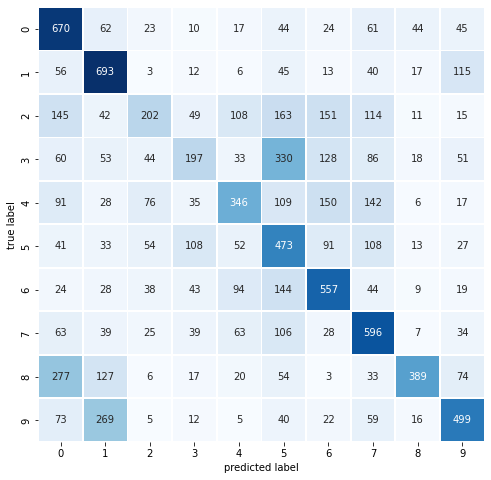

In [ ]:
plot_confusion_matrix(y_test,pred2)

#**Experiment 3 - CNN with 2 layers (no regularization)**

1. two Conv Layer + Pooling Layers
2. no regularization
3. Without Dropout & Batch_Normalization layer

In [ ]:
model_3 = models.Sequential()
model_3.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model_3.add(layers.MaxPool2D((2, 2),strides=2))
model_3.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_3.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(units=384, activation=tf.nn.relu))
model_3.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense_3 (Dense)             (None, 384)              

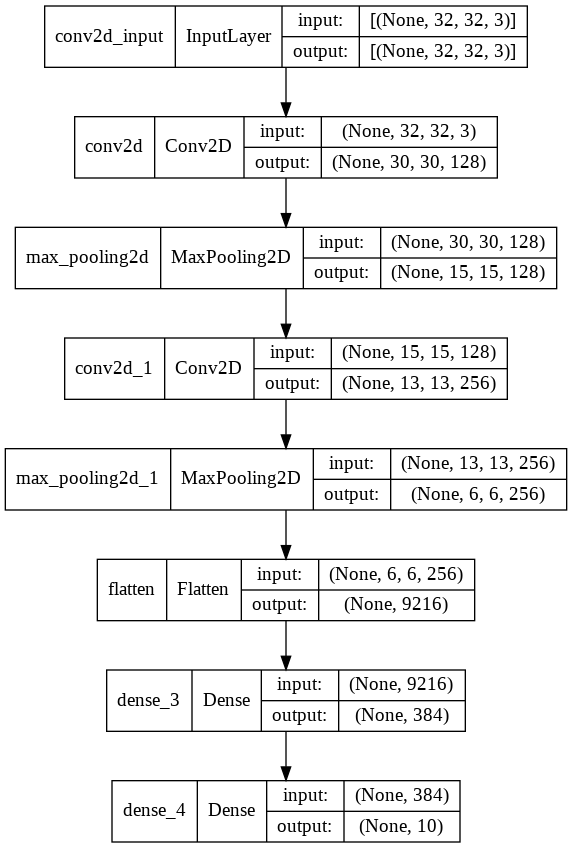

In [ ]:
keras.utils.plot_model(model_3, "CIFAR10.png", show_shapes=True) 

In [ ]:
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
#training the model

start_time = time.time()

history_3 = model_3.fit(x_train_norm
                    ,y_train_split
                    ,epochs=100
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint(path +'model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]
)

end_time = time.time() 

Epoch 1/100
88/88 [==============================] - 11s 40ms/step - loss: 1.7003 - accuracy: 0.3869 - val_loss: 1.3822 - val_accuracy: 0.5066
Epoch 2/100
88/88 [==============================] - 3s 32ms/step - loss: 1.2940 - accuracy: 0.5439 - val_loss: 1.2134 - val_accuracy: 0.5668
Epoch 3/100
88/88 [==============================] - 3s 32ms/step - loss: 1.1249 - accuracy: 0.6065 - val_loss: 1.1109 - val_accuracy: 0.6142
Epoch 4/100
88/88 [==============================] - 3s 32ms/step - loss: 1.0230 - accuracy: 0.6458 - val_loss: 1.0387 - val_accuracy: 0.6296
Epoch 5/100
88/88 [==============================] - 3s 32ms/step - loss: 0.9471 - accuracy: 0.6728 - val_loss: 0.9659 - val_accuracy: 0.6654
Epoch 6/100
88/88 [==============================] - 3s 30ms/step - loss: 0.8760 - accuracy: 0.6989 - val_loss: 0.9472 - val_accuracy: 0.6652
Epoch 7/100
88/88 [==============================] - 3s 33ms/step - loss: 0.8128 - accuracy: 0.7212 - val_loss: 0.9037 - val_accuracy: 0.6828
Epoch

In [ ]:
#tracking training time
train_time = end_time - start_time

In [ ]:
loss, accuracy = model_3.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 3ms/step - loss: 1.0200 - accuracy: 0.7104
test set accuracy:  71.03999853134155


In [ ]:
preds = model_3.predict(x_test_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


In [ ]:
model_3_score = score_track(model_3, x_train_norm, y_train_split, x_valid_norm, y_valid_split, x_test_norm, y_test)

model_3_score['train_time'] = train_time

In [ ]:
history_dict = history_3.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
14,0.435,0.853,0.852,0.720
15,0.407,0.864,0.871,0.722
16,0.350,0.884,0.918,0.714
17,0.313,0.897,0.919,0.717
18,0.265,0.917,0.995,0.713


In [ ]:
losses = history_3.history['loss']
accs = history_3.history['accuracy']
val_losses = history_3.history['val_loss']
val_accs = history_3.history['val_accuracy']
epochs = len(losses)

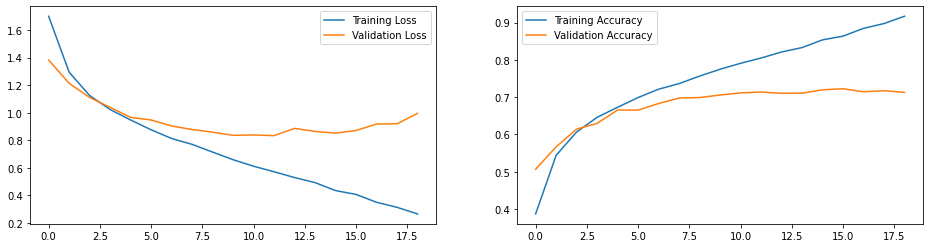

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred3= model_3.predict(x_test_norm)
pred3=np.argmax(pred3, axis=1)

In [ ]:
print_validation_report(y_test, pred3)

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.68      0.74      1000
           1       0.87      0.80      0.84      1000
           2       0.63      0.59      0.61      1000
           3       0.59      0.43      0.49      1000
           4       0.53      0.82      0.65      1000
           5       0.64      0.60      0.62      1000
           6       0.76      0.78      0.77      1000
           7       0.78      0.74      0.76      1000
           8       0.77      0.86      0.81      1000
           9       0.80      0.81      0.81      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000

Accuracy Score: 0.7104
Root Mean Square Error: 2.1785775175558935


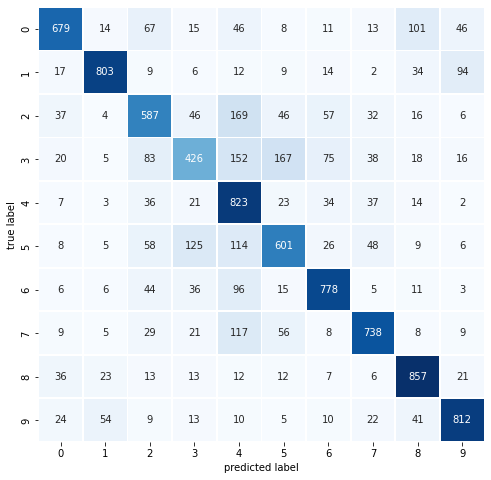

In [ ]:
plot_confusion_matrix(y_test,pred3)

#**Experiment 4 - CNN with 3 layers (no regularization)**

1. 3 Conv Layer + Pooling Layers
2. no regularization
3. Without Dropout & Batch_Normalization layer

In [ ]:
model_4 = models.Sequential()
model_4.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model_4.add(layers.MaxPool2D((2, 2),strides=2))
model_4.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_4.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_4.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_4.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_4.add(layers.Flatten())
model_4.add(layers.Dense(units=384, activation=tf.nn.relu))
model_4.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 512)         1180160   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 512)       

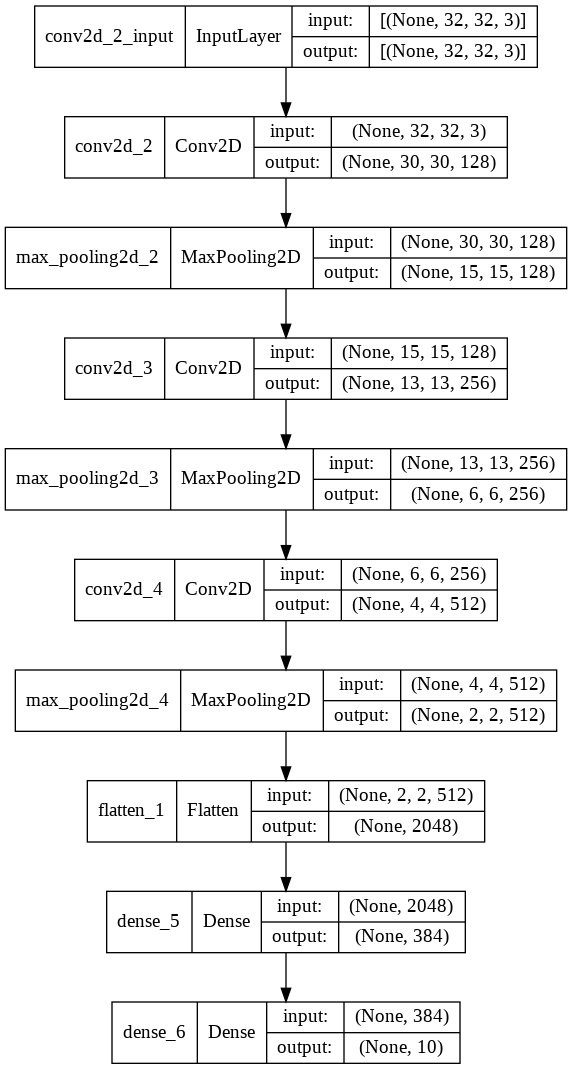

In [ ]:
keras.utils.plot_model(model_4, "CIFAR10.png", show_shapes=True) 

In [ ]:
model_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
#model training

start_time = time.time()

history_4 = model_4.fit(x_train_norm
                    ,y_train_split
                    ,epochs=100
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint(path +'model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

end_time = time.time()

Epoch 1/100
88/88 [==============================] - 4s 44ms/step - loss: 1.8274 - accuracy: 0.3283 - val_loss: 1.4919 - val_accuracy: 0.4472
Epoch 2/100
88/88 [==============================] - 3s 37ms/step - loss: 1.3601 - accuracy: 0.5065 - val_loss: 1.2771 - val_accuracy: 0.5446
Epoch 3/100
88/88 [==============================] - 3s 37ms/step - loss: 1.1647 - accuracy: 0.5920 - val_loss: 1.1105 - val_accuracy: 0.6086
Epoch 4/100
88/88 [==============================] - 3s 38ms/step - loss: 1.0203 - accuracy: 0.6442 - val_loss: 0.9835 - val_accuracy: 0.6532
Epoch 5/100
88/88 [==============================] - 3s 37ms/step - loss: 0.9352 - accuracy: 0.6768 - val_loss: 0.9220 - val_accuracy: 0.6708
Epoch 6/100
88/88 [==============================] - 3s 37ms/step - loss: 0.8457 - accuracy: 0.7087 - val_loss: 0.8697 - val_accuracy: 0.7040
Epoch 7/100
88/88 [==============================] - 3s 37ms/step - loss: 0.7641 - accuracy: 0.7381 - val_loss: 0.8338 - val_accuracy: 0.7146
Epoch 

In [ ]:
#tracking training time
train_time = end_time - start_time

In [ ]:
loss, accuracy = model_4.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 3ms/step - loss: 0.8195 - accuracy: 0.7289
test set accuracy:  72.89000153541565


In [ ]:
preds = model_4.predict(x_test_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


In [ ]:
model_4_score = score_track(model_4, x_train_norm, y_train_split, x_valid_norm, y_valid_split, x_test_norm, y_test)

model_4_score['train_time'] = train_time

In [ ]:
history_dict = history_4.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
7,0.698,0.760,0.823,0.715
8,0.645,0.777,0.782,0.735
9,0.588,0.800,0.838,0.720
10,0.531,0.818,0.805,0.728
11,0.486,0.833,0.819,0.731


In [ ]:
losses = history_4.history['loss']
accs = history_4.history['accuracy']
val_losses = history_4.history['val_loss']
val_accs = history_4.history['val_accuracy']
epochs = len(losses)

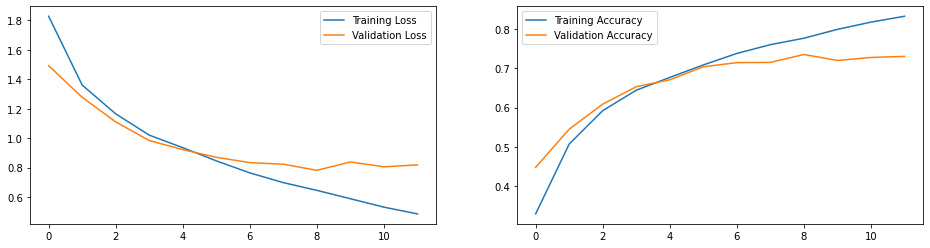

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred4= model_4.predict(x_test_norm)
pred4=np.argmax(pred4, axis=1)

In [ ]:
print_validation_report(y_test, pred4)

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1000
           1       0.81      0.86      0.84      1000
           2       0.68      0.59      0.63      1000
           3       0.57      0.55      0.56      1000
           4       0.71      0.68      0.70      1000
           5       0.68      0.61      0.64      1000
           6       0.73      0.84      0.78      1000
           7       0.79      0.77      0.78      1000
           8       0.68      0.92      0.78      1000
           9       0.90      0.71      0.79      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000

Accuracy Score: 0.7289
Root Mean Square Error: 2.1680867141329934


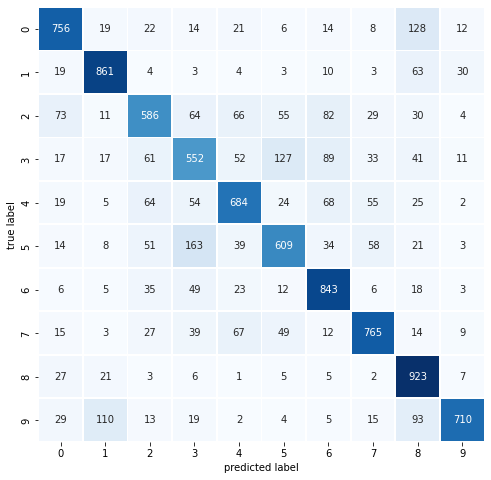

In [ ]:
plot_confusion_matrix(y_test,pred4)

#**Experiment 5 - DNN/CNN with regullarization**

In this experiment, we will redo all four experiments above by adding some regularization techniques
options under considerations
- dropout layer
- batchnormalization
- L1/L2 regularization

**DNN 2 layers with regularization**

In [ ]:
model_5 = models.Sequential()
model_5.add(layers.Dense(input_shape = [width*height*channel], units=384, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model_5.add(layers.Dropout(0.3))
model_5.add(layers.Dense(name = 'output_layer', units=10, activation=tf.nn.softmax))

In [ ]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 384)               1180032   
                                                                 
 dropout (Dropout)           (None, 384)               0         
                                                                 
 output_layer (Dense)        (None, 10)                3850      
                                                                 
Total params: 1,183,882
Trainable params: 1,183,882
Non-trainable params: 0
_________________________________________________________________


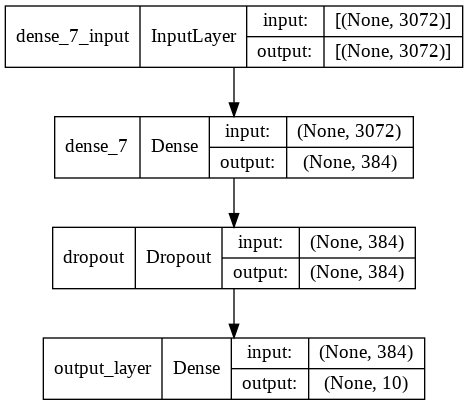

In [ ]:
keras.utils.plot_model(model_5, "cifar10_model1.png", show_shapes=True) 

In [ ]:
model_5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #set from_logits = False since Softmax has been applied in output layer
              metrics=['accuracy'])

In [ ]:
start_time = time.time()

history_5 = model_5.fit(
    x_train_flat,
    y_train_split,
    batch_size = 512,
    epochs = 100, 
    validation_data=(x_valid_flat, y_valid_split),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
               tf.keras.callbacks.ModelCheckpoint(path +'model_{val_accuracy:.4f}.h5', save_best_only=True,save_weights_only=False, monitor='val_accuracy')]
)    


end_time = time.time()

Epoch 1/100
88/88 [==============================] - 1s 10ms/step - loss: 2.7974 - accuracy: 0.2144 - val_loss: 2.3671 - val_accuracy: 0.3206
Epoch 2/100
88/88 [==============================] - 1s 12ms/step - loss: 2.2896 - accuracy: 0.3024 - val_loss: 2.1507 - val_accuracy: 0.3524
Epoch 3/100
88/88 [==============================] - 1s 11ms/step - loss: 2.1336 - accuracy: 0.3252 - val_loss: 2.0293 - val_accuracy: 0.3656
Epoch 4/100
88/88 [==============================] - 1s 6ms/step - loss: 2.0360 - accuracy: 0.3420 - val_loss: 1.9374 - val_accuracy: 0.3678
Epoch 5/100
88/88 [==============================] - 1s 7ms/step - loss: 1.9738 - accuracy: 0.3456 - val_loss: 1.8933 - val_accuracy: 0.3876
Epoch 6/100
88/88 [==============================] - 1s 7ms/step - loss: 1.9181 - accuracy: 0.3543 - val_loss: 1.8387 - val_accuracy: 0.3994
Epoch 7/100
88/88 [==============================] - 1s 6ms/step - loss: 1.8858 - accuracy: 0.3572 - val_loss: 1.7973 - val_accuracy: 0.3974
Epoch 8/10

In [ ]:
#tracking training time
train_time = end_time - start_time

In [ ]:
#model evaluation

loss, accuracy = model_5.evaluate(x_test_flat, y_test)
print('test set accuracy: ', accuracy * 100)

test_accuracy.append(accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 1.6682 - accuracy: 0.4345
test set accuracy:  43.45000088214874


In [ ]:
model_5_score = score_track(model_5, x_train_flat, y_train_split, x_valid_flat, y_valid_split, x_test_flat, y_test)

In [ ]:
model_5_score

{'accuracy_test': 0.4345,
 'accuracy_train': 0.4425777777777778,
 'accuracy_valid': 0.4164,
 'f1_test': 0.43074221574310545,
 'precision_test': 0.44488724557429177,
 'recall_test': 0.4345}

In [ ]:
model_5_score['train_time'] = train_time

In [ ]:
#make prediction

preds = model_5.predict(x_test_flat)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


In [ ]:
history_dict = history_5.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
12,1.784,0.379,1.703,0.414
13,1.777,0.379,1.695,0.418
14,1.769,0.380,1.708,0.418
15,1.770,0.381,1.709,0.415
16,1.761,0.383,1.691,0.416


In [ ]:
losses = history_5.history['loss']
accs = history_5.history['accuracy']
val_losses = history_5.history['val_loss']
val_accs = history_5.history['val_accuracy']
epochs = len(losses)

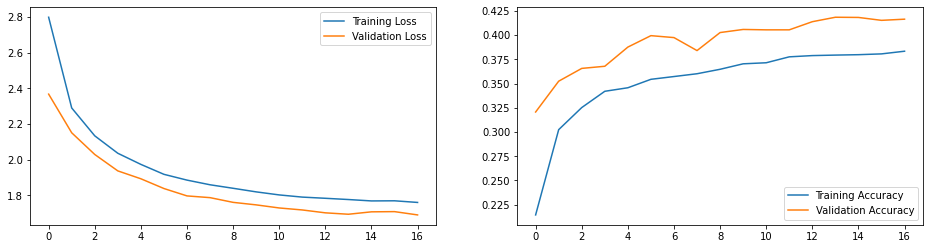

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
#confusion matrix generation

pred5= model_5.predict(x_test_flat)
pred5=np.argmax(pred5, axis=1)

In [ ]:
print_validation_report(y_test, pred5)

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.36      0.44      1000
           1       0.58      0.51      0.54      1000
           2       0.32      0.24      0.27      1000
           3       0.30      0.32      0.31      1000
           4       0.42      0.30      0.35      1000
           5       0.33      0.42      0.37      1000
           6       0.39      0.65      0.49      1000
           7       0.52      0.45      0.48      1000
           8       0.51      0.62      0.56      1000
           9       0.51      0.49      0.50      1000

    accuracy                           0.43     10000
   macro avg       0.44      0.43      0.43     10000
weighted avg       0.44      0.43      0.43     10000

Accuracy Score: 0.4345
Root Mean Square Error: 3.20452804637438


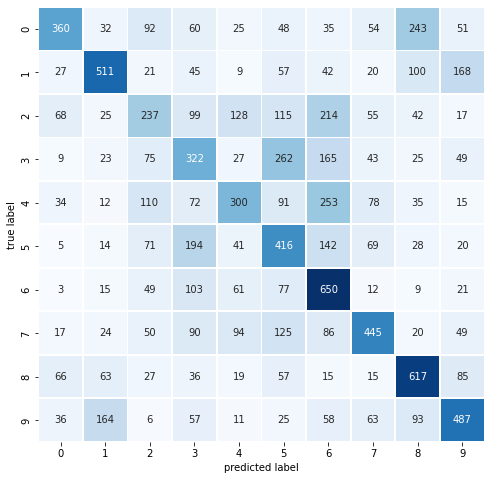

In [ ]:
plot_confusion_matrix(y_test,pred5)

**DNN 3 layers with regularization**

In [ ]:
model_6 = models.Sequential()
model_6.add(layers.Dense(input_shape = [width*height*channel], units=384, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model_6.add(layers.Dropout(0.3))
model_6.add(layers.Dense(input_shape = [384], units=128, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model_6.add(layers.Dropout(0.3))
model_6.add(layers.Dense(name = 'output_layer', units=10, activation=tf.nn.softmax))

In [ ]:
model_6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 384)               1180032   
                                                                 
 dropout_1 (Dropout)         (None, 384)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               49280     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 1,230,602
Trainable params: 1,230,602
Non-trainable params: 0
_________________________________________________________________


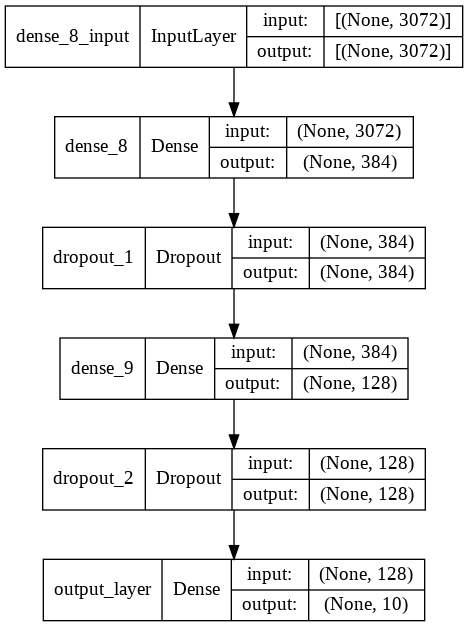

In [ ]:
keras.utils.plot_model(model_6, "cifar10_model1.png", show_shapes=True) 

In [ ]:
model_6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #set from_logits = False since Softmax has been applied in output layer
              metrics=['accuracy'])

In [ ]:
start_time = time.time()

history_6 = model_6.fit(
    x_train_flat,
    y_train_split,
    batch_size = 512,
    epochs = 100, 
    validation_data=(x_valid_flat, y_valid_split),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
               tf.keras.callbacks.ModelCheckpoint(path +'model_{val_accuracy:.4f}.h5', save_best_only=True,save_weights_only=False, monitor='val_accuracy')]
)

end_time = time.time()

Epoch 1/100
88/88 [==============================] - 1s 10ms/step - loss: 2.8355 - accuracy: 0.2072 - val_loss: 2.4083 - val_accuracy: 0.3210
Epoch 2/100
88/88 [==============================] - 1s 11ms/step - loss: 2.3447 - accuracy: 0.2986 - val_loss: 2.1987 - val_accuracy: 0.3444
Epoch 3/100
88/88 [==============================] - 1s 7ms/step - loss: 2.1672 - accuracy: 0.3212 - val_loss: 2.0262 - val_accuracy: 0.3624
Epoch 4/100
88/88 [==============================] - 1s 6ms/step - loss: 2.0352 - accuracy: 0.3430 - val_loss: 1.9589 - val_accuracy: 0.3580
Epoch 5/100
88/88 [==============================] - 1s 7ms/step - loss: 1.9630 - accuracy: 0.3512 - val_loss: 1.8673 - val_accuracy: 0.3836
Epoch 6/100
88/88 [==============================] - 1s 7ms/step - loss: 1.9167 - accuracy: 0.3568 - val_loss: 1.8196 - val_accuracy: 0.3968
Epoch 7/100
88/88 [==============================] - 1s 7ms/step - loss: 1.8814 - accuracy: 0.3631 - val_loss: 1.7903 - val_accuracy: 0.4014
Epoch 8/100

In [ ]:
#tracking training time
train_time = end_time - start_time

In [ ]:
#model evaluation

loss, accuracy = model_6.evaluate(x_test_flat, y_test)
print('test set accuracy: ', accuracy * 100)

test_accuracy.append(accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 1.7037 - accuracy: 0.4163
test set accuracy:  41.62999987602234


In [ ]:
model_6_score = score_track(model_6, x_train_flat, y_train_split, x_valid_flat, y_valid_split, x_test_flat, y_test)

In [ ]:
model_6_score

{'accuracy_test': 0.4163,
 'accuracy_train': 0.42793333333333333,
 'accuracy_valid': 0.399,
 'f1_test': 0.3981407616170304,
 'precision_test': 0.4323769806109931,
 'recall_test': 0.4163}

In [ ]:
model_6_score['train_time'] = train_time

In [ ]:
#make prediction

preds = model_6.predict(x_test_flat)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


In [ ]:
history_dict = history_6.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
9,1.795,0.385,1.744,0.400
10,1.793,0.385,1.713,0.418
11,1.786,0.383,1.702,0.412
12,1.773,0.388,1.695,0.413
13,1.765,0.387,1.726,0.399


In [ ]:
losses = history_6.history['loss']
accs = history_6.history['accuracy']
val_losses = history_6.history['val_loss']
val_accs = history_6.history['val_accuracy']
epochs = len(losses)

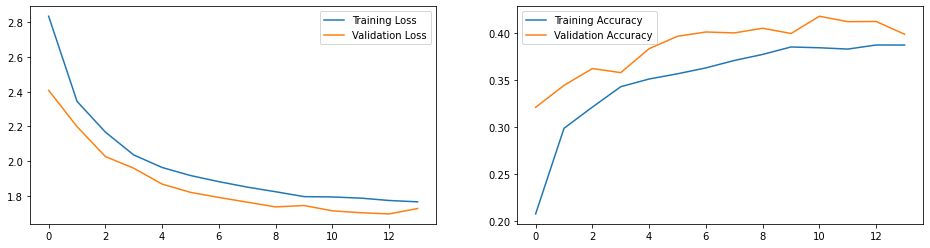

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
#confusion matrix generation

pred6= model_6.predict(x_test_flat)
pred6=np.argmax(pred6, axis=1)

In [ ]:
print_validation_report(y_test, pred6)

Classification Report
              precision    recall  f1-score   support

           0       0.49      0.44      0.46      1000
           1       0.49      0.61      0.54      1000
           2       0.32      0.15      0.21      1000
           3       0.34      0.18      0.23      1000
           4       0.36      0.39      0.38      1000
           5       0.45      0.26      0.32      1000
           6       0.32      0.75      0.45      1000
           7       0.63      0.31      0.41      1000
           8       0.45      0.70      0.55      1000
           9       0.48      0.38      0.43      1000

    accuracy                           0.42     10000
   macro avg       0.43      0.42      0.40     10000
weighted avg       0.43      0.42      0.40     10000

Accuracy Score: 0.4163
Root Mean Square Error: 3.3738553614522364


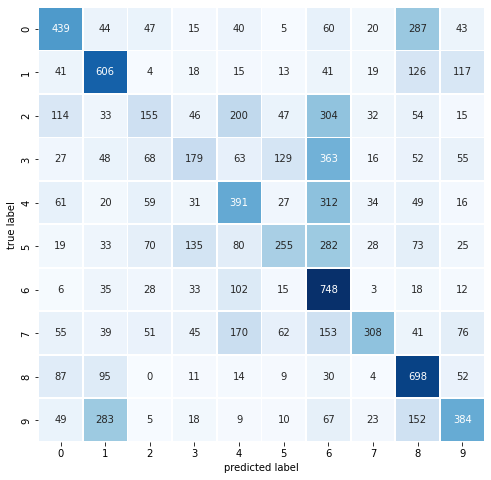

In [ ]:
plot_confusion_matrix(y_test,pred6)

**CNN 2 layers with regularization**

In [ ]:
model_7 = models.Sequential()
model_7.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model_7.add(layers.MaxPool2D((2, 2),strides=2))
model_7.add(layers.Dropout(0.3))
model_7.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_7.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_7.add(layers.Dropout(0.3))
model_7.add(layers.Flatten())
model_7.add(layers.BatchNormalization())
model_7.add(layers.Dense(units=384, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model_7.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 256)        

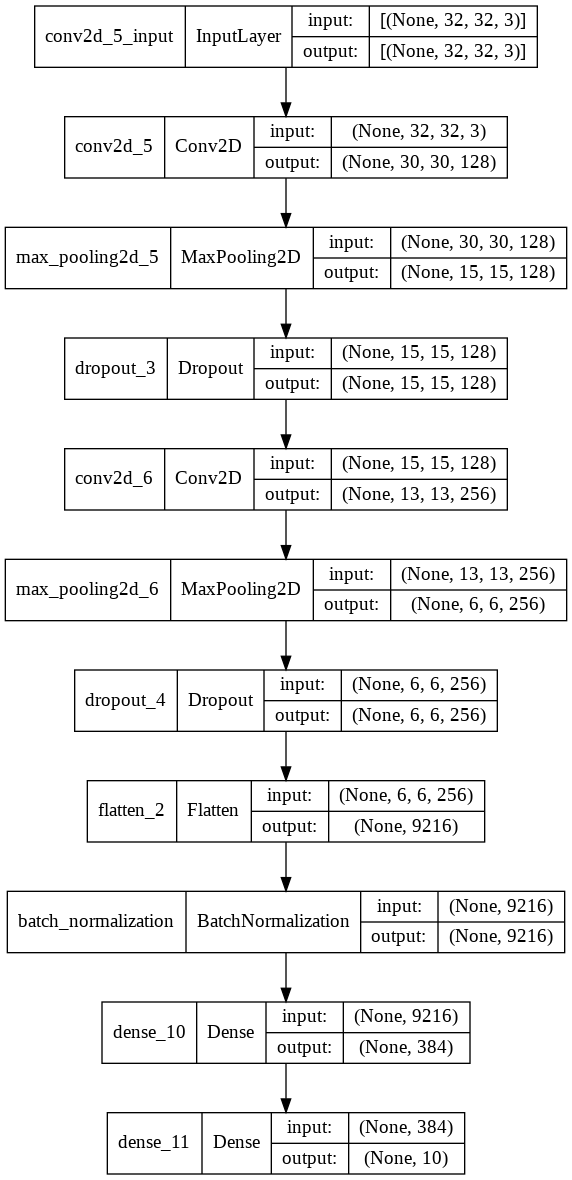

In [ ]:
keras.utils.plot_model(model_7, "CIFAR10.png", show_shapes=True) 

In [ ]:
model_7.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
#training the model

start_time = time.time()

history_7 = model_7.fit(x_train_norm
                    ,y_train_split
                    ,epochs=100
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint(path +'model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]
)

end_time = time.time() 

Epoch 1/100
88/88 [==============================] - 4s 38ms/step - loss: 2.1612 - accuracy: 0.4699 - val_loss: 2.7192 - val_accuracy: 0.3216
Epoch 2/100
88/88 [==============================] - 3s 36ms/step - loss: 1.4715 - accuracy: 0.6379 - val_loss: 2.4585 - val_accuracy: 0.5940
Epoch 3/100
88/88 [==============================] - 3s 34ms/step - loss: 1.1880 - accuracy: 0.7005 - val_loss: 2.2273 - val_accuracy: 0.5804
Epoch 4/100
88/88 [==============================] - 3s 36ms/step - loss: 1.0273 - accuracy: 0.7435 - val_loss: 1.9199 - val_accuracy: 0.6372
Epoch 5/100
88/88 [==============================] - 3s 37ms/step - loss: 0.9251 - accuracy: 0.7784 - val_loss: 1.5284 - val_accuracy: 0.7160
Epoch 6/100
88/88 [==============================] - 3s 36ms/step - loss: 0.8619 - accuracy: 0.8040 - val_loss: 1.2134 - val_accuracy: 0.7290
Epoch 7/100
88/88 [==============================] - 3s 37ms/step - loss: 0.8192 - accuracy: 0.8237 - val_loss: 1.0682 - val_accuracy: 0.7460
Epoch 

In [ ]:
#tracking training time
train_time = end_time - start_time

In [ ]:
loss, accuracy = model_7.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 3ms/step - loss: 1.3004 - accuracy: 0.7529
test set accuracy:  75.29000043869019


In [ ]:
preds = model_7.predict(x_test_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


In [ ]:
model_7_score = score_track(model_7, x_train_norm, y_train_split, x_valid_norm, y_valid_split, x_test_norm, y_test)

model_7_score['train_time'] = train_time

In [ ]:
history_dict = history_7.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
18,0.669,0.918,1.201,0.769
19,0.665,0.922,1.197,0.772
20,0.665,0.923,1.219,0.760
21,0.663,0.924,1.208,0.767
22,0.654,0.927,1.276,0.755


In [ ]:
losses = history_7.history['loss']
accs = history_7.history['accuracy']
val_losses = history_7.history['val_loss']
val_accs = history_7.history['val_accuracy']
epochs = len(losses)

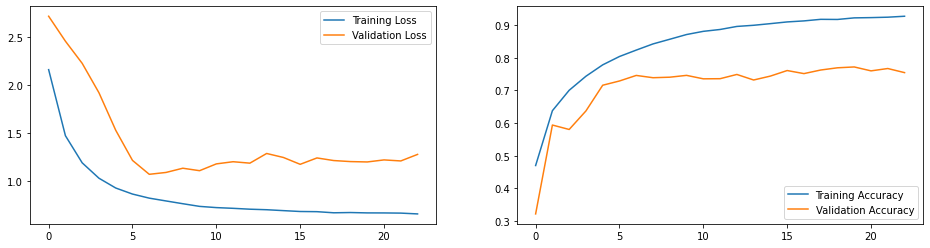

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred7= model_7.predict(x_test_norm)
pred7=np.argmax(pred7, axis=1)

In [ ]:
print_validation_report(y_test, pred7)

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      1000
           1       0.87      0.88      0.87      1000
           2       0.73      0.60      0.66      1000
           3       0.59      0.60      0.59      1000
           4       0.65      0.79      0.72      1000
           5       0.74      0.56      0.64      1000
           6       0.67      0.91      0.77      1000
           7       0.86      0.76      0.81      1000
           8       0.89      0.81      0.84      1000
           9       0.83      0.83      0.83      1000

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.75      0.75     10000

Accuracy Score: 0.7529
Root Mean Square Error: 2.0256603861457134


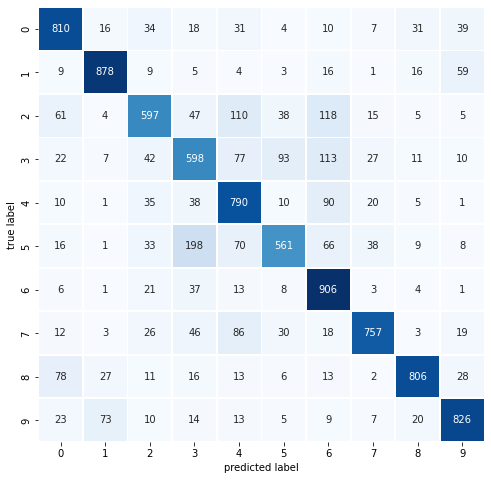

In [ ]:
plot_confusion_matrix(y_test,pred7)

**CNN 3 layers with regularization**

In [ ]:
model_8 = models.Sequential()
model_8.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model_8.add(layers.MaxPool2D((2, 2),strides=2))
model_8.add(layers.Dropout(0.3))
model_8.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_8.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_8.add(layers.Dropout(0.3))
model_8.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_8.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_8.add(layers.Dropout(0.3))
model_8.add(layers.Flatten())
model_8.add(layers.BatchNormalization())
model_8.add(layers.Dense(units=384, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model_8.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_8.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 15, 15, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 6, 6, 256)        

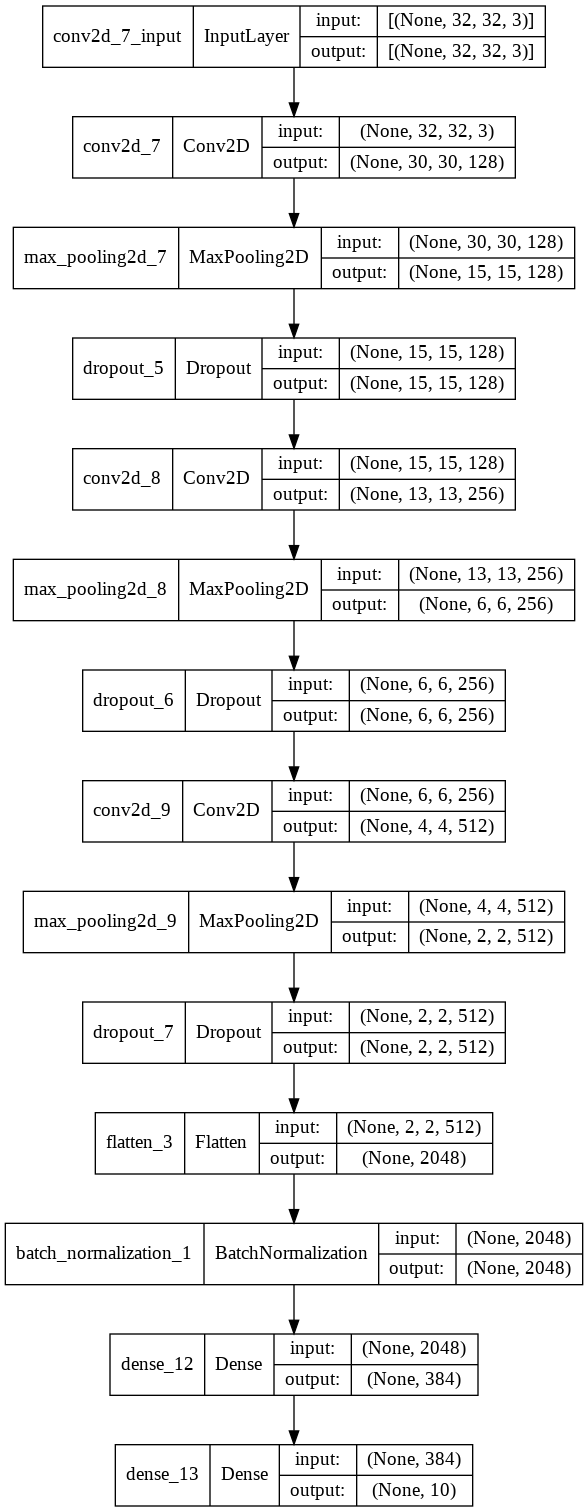

In [ ]:
keras.utils.plot_model(model_8, "CIFAR10.png", show_shapes=True) 

In [ ]:
model_8.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
#model training

start_time = time.time()

history_8 = model_8.fit(x_train_norm
                    ,y_train_split
                    ,epochs=100
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint(path +'model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

end_time = time.time()

Epoch 1/100
88/88 [==============================] - 5s 47ms/step - loss: 2.1349 - accuracy: 0.4134 - val_loss: 2.5205 - val_accuracy: 0.3898
Epoch 2/100
88/88 [==============================] - 4s 40ms/step - loss: 1.5034 - accuracy: 0.5802 - val_loss: 2.1925 - val_accuracy: 0.5938
Epoch 3/100
88/88 [==============================] - 4s 40ms/step - loss: 1.2134 - accuracy: 0.6515 - val_loss: 1.8579 - val_accuracy: 0.6494
Epoch 4/100
88/88 [==============================] - 4s 41ms/step - loss: 1.0608 - accuracy: 0.6866 - val_loss: 1.4919 - val_accuracy: 0.7126
Epoch 5/100
88/88 [==============================] - 3s 39ms/step - loss: 0.9495 - accuracy: 0.7136 - val_loss: 1.1846 - val_accuracy: 0.7044
Epoch 6/100
88/88 [==============================] - 4s 41ms/step - loss: 0.8636 - accuracy: 0.7395 - val_loss: 0.9355 - val_accuracy: 0.7372
Epoch 7/100
88/88 [==============================] - 3s 38ms/step - loss: 0.8016 - accuracy: 0.7583 - val_loss: 0.8947 - val_accuracy: 0.7326
Epoch 

In [ ]:
#tracking training time
train_time = end_time - start_time

In [ ]:
loss, accuracy = model_8.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 4ms/step - loss: 0.7650 - accuracy: 0.7988
test set accuracy:  79.8799991607666


In [ ]:
preds = model_8.predict(x_test_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


In [ ]:
model_8_score = score_track(model_8, x_train_norm, y_train_split, x_valid_norm, y_valid_split, x_test_norm, y_test)

model_8_score['train_time'] = train_time

In [ ]:
history_dict = history_8.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
19,0.497,0.866,0.745,0.792
20,0.488,0.872,0.723,0.804
21,0.480,0.874,0.735,0.801
22,0.460,0.881,0.753,0.794
23,0.465,0.881,0.741,0.801


In [ ]:
losses = history_8.history['loss']
accs = history_8.history['accuracy']
val_losses = history_8.history['val_loss']
val_accs = history_8.history['val_accuracy']
epochs = len(losses)

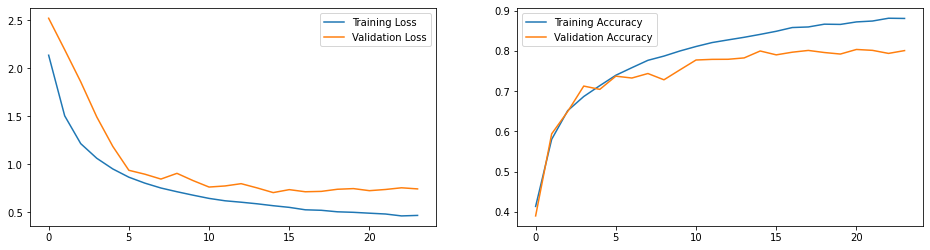

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred8= model_8.predict(x_test_norm)
pred8=np.argmax(pred8, axis=1)

In [ ]:
print_validation_report(y_test, pred8)

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1000
           1       0.91      0.89      0.90      1000
           2       0.74      0.69      0.71      1000
           3       0.72      0.57      0.64      1000
           4       0.81      0.76      0.78      1000
           5       0.71      0.78      0.74      1000
           6       0.76      0.91      0.83      1000
           7       0.81      0.86      0.83      1000
           8       0.78      0.93      0.85      1000
           9       0.87      0.86      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

Accuracy Score: 0.7988
Root Mean Square Error: 1.840135864549137


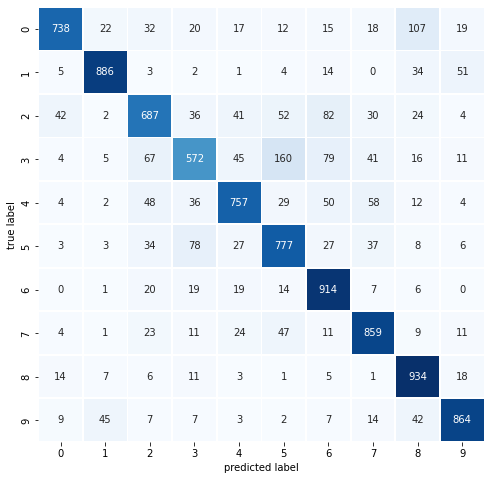

In [ ]:
plot_confusion_matrix(y_test,pred8)

**Experiment 5-C - four segment with Data Augmentation**

https://www.tensorflow.org/tutorials/images/data_augmentation

adding data augmentation layers into the two CNN models without regularization

**CNN 2 layers with regularization**

In [ ]:
model_9 = models.Sequential()
model_9.add(layers.RandomFlip("horizontal_and_vertical"))
model_9.add(layers.RandomRotation(0.2))
model_9.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model_9.add(layers.MaxPool2D((2, 2),strides=2))
model_9.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_9.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_9.add(layers.Flatten())
model_9.add(layers.Dense(units=384, activation=tf.nn.relu))
model_9.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_9.build((None,32, 32, 3))
model_9.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 random_rotation (RandomRota  (None, 32, 32, 3)        0         
 tion)                                                           
                                                                 
 conv2d_10 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 256)       

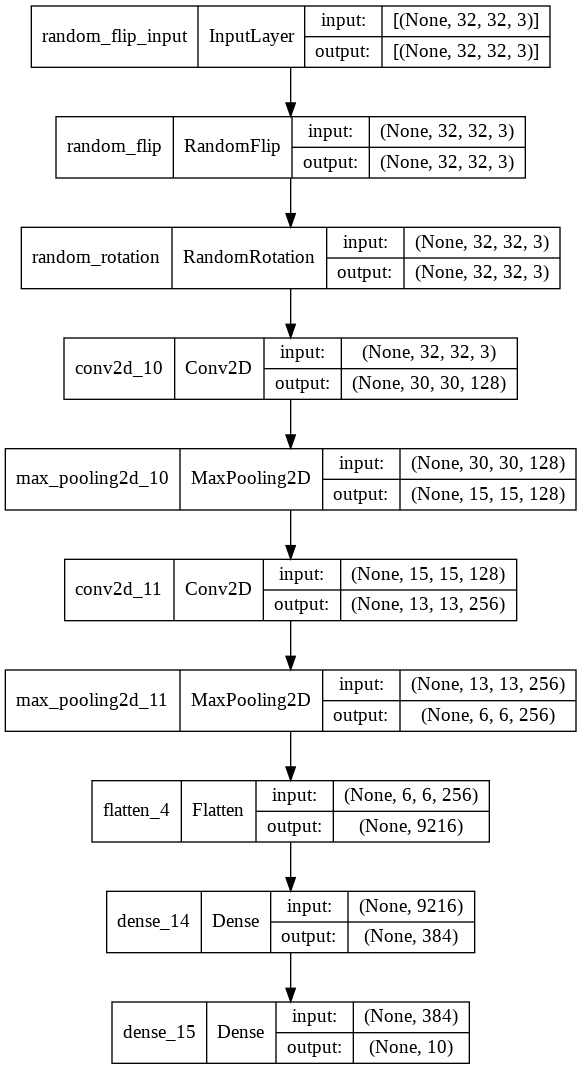

In [ ]:
keras.utils.plot_model(model_9, "CIFAR10.png", show_shapes=True) 

In [ ]:
model_9.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
#training the model

start_time = time.time()

history_9 = model_9.fit(x_train_norm
                    ,y_train_split
                    ,epochs=100
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint(path +'model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]
)

end_time = time.time() 

Epoch 1/100
88/88 [==============================] - 4s 36ms/step - loss: 1.9455 - accuracy: 0.2859 - val_loss: 1.8108 - val_accuracy: 0.3560
Epoch 2/100
88/88 [==============================] - 3s 38ms/step - loss: 1.6844 - accuracy: 0.3928 - val_loss: 1.7431 - val_accuracy: 0.3820
Epoch 3/100
88/88 [==============================] - 3s 33ms/step - loss: 1.5834 - accuracy: 0.4299 - val_loss: 1.5806 - val_accuracy: 0.4298
Epoch 4/100
88/88 [==============================] - 3s 36ms/step - loss: 1.5272 - accuracy: 0.4514 - val_loss: 1.4937 - val_accuracy: 0.4650
Epoch 5/100
88/88 [==============================] - 3s 35ms/step - loss: 1.4728 - accuracy: 0.4761 - val_loss: 1.4270 - val_accuracy: 0.4818
Epoch 6/100
88/88 [==============================] - 3s 33ms/step - loss: 1.4224 - accuracy: 0.4903 - val_loss: 1.3960 - val_accuracy: 0.4994
Epoch 7/100
88/88 [==============================] - 3s 34ms/step - loss: 1.4048 - accuracy: 0.4999 - val_loss: 1.3366 - val_accuracy: 0.5292
Epoch 

In [ ]:
#tracking training time
train_time = end_time - start_time

In [ ]:
loss, accuracy = model_9.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 3ms/step - loss: 1.2277 - accuracy: 0.5680
test set accuracy:  56.80000185966492


In [ ]:
preds = model_9.predict(x_test_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


In [ ]:
model_9_score = score_track(model_9, x_train_norm, y_train_split, x_valid_norm, y_valid_split, x_test_norm, y_test)

model_9_score['train_time'] = train_time

In [ ]:
history_dict = history_9.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
9,1.294,0.541,1.358,0.527
10,1.274,0.549,1.254,0.570
11,1.244,0.559,1.272,0.555
12,1.233,0.564,1.245,0.568
13,1.212,0.571,1.247,0.562


In [ ]:
losses = history_9.history['loss']
accs = history_9.history['accuracy']
val_losses = history_9.history['val_loss']
val_accs = history_9.history['val_accuracy']
epochs = len(losses)

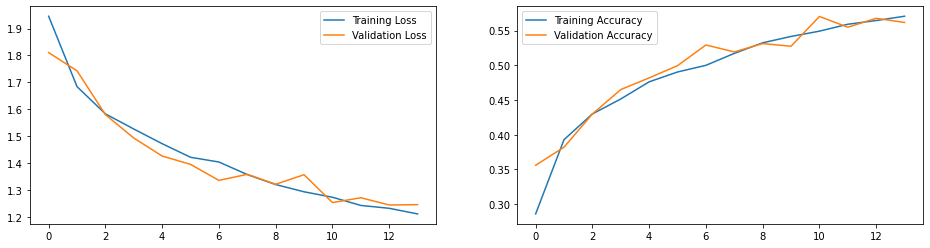

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred9= model_9.predict(x_test_norm)
pred9=np.argmax(pred9, axis=1)

In [ ]:
print_validation_report(y_test, pred9)

Classification Report
              precision    recall  f1-score   support

           0       0.56      0.67      0.61      1000
           1       0.67      0.73      0.70      1000
           2       0.61      0.22      0.32      1000
           3       0.51      0.25      0.34      1000
           4       0.53      0.53      0.53      1000
           5       0.61      0.44      0.51      1000
           6       0.56      0.80      0.66      1000
           7       0.51      0.63      0.57      1000
           8       0.59      0.72      0.65      1000
           9       0.54      0.68      0.60      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.55     10000
weighted avg       0.57      0.57      0.55     10000

Accuracy Score: 0.568
Root Mean Square Error: 2.9559262507714905


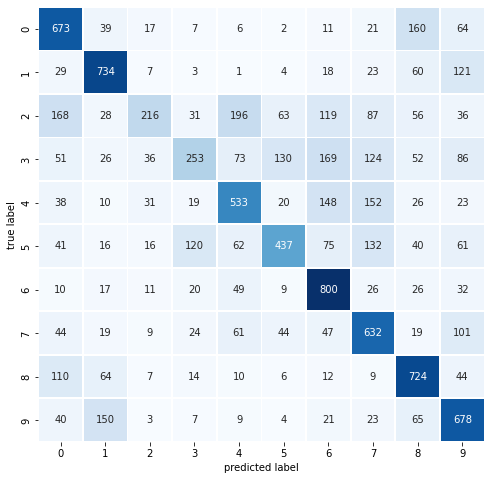

In [ ]:
plot_confusion_matrix(y_test,pred9)

**CNN 3 layers without regularization = Data Augmentation**

In [ ]:
model_10 = models.Sequential()
model_10.add(layers.RandomFlip("horizontal_and_vertical"))
model_10.add(layers.RandomRotation(0.2))
model_10.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(32, 32, 3)))
model_10.add(layers.MaxPool2D((2, 2),strides=2))
model_10.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_10.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_10.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_10.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_10.add(layers.Flatten())
model_10.add(layers.Dense(units=384, activation=tf.nn.relu))
model_10.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_10.build((None,32, 32, 3))
model_10.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 random_rotation_1 (RandomRo  (None, 32, 32, 3)        0         
 tation)                                                         
                                                                 
 conv2d_12 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 256)       

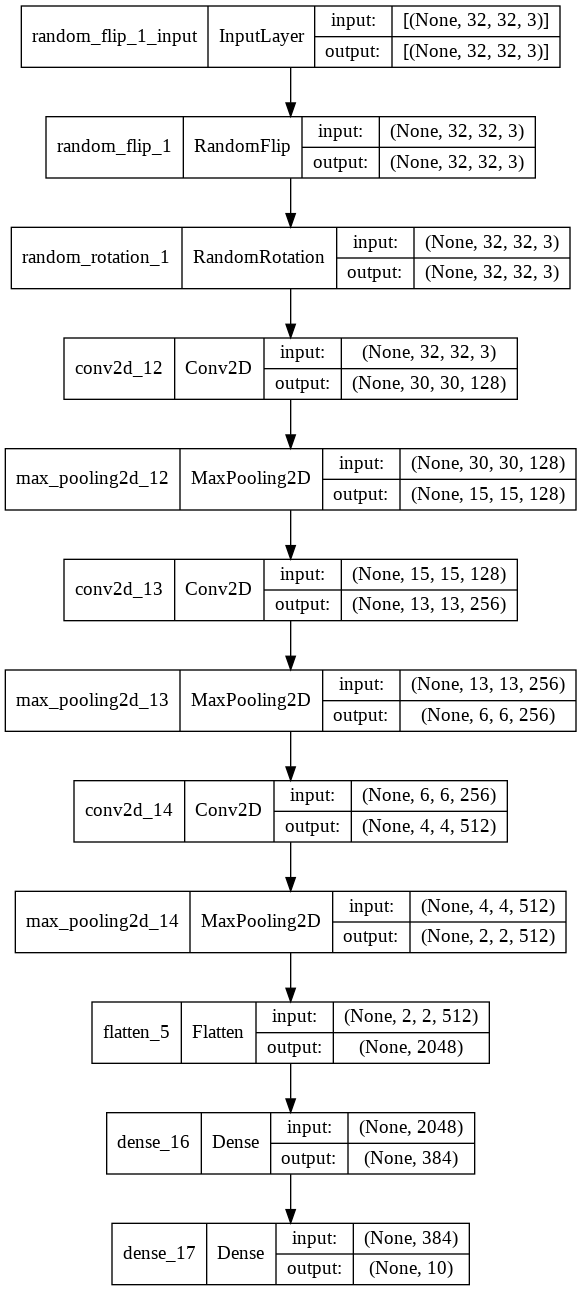

In [ ]:
keras.utils.plot_model(model_10, "CIFAR10.png", show_shapes=True) 

In [ ]:
model_10.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
#model training

start_time = time.time()

history_10 = model_10.fit(x_train_norm
                    ,y_train_split
                    ,epochs=100
                    ,batch_size=512
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint(path +'model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

end_time = time.time()

Epoch 1/100
88/88 [==============================] - 4s 41ms/step - loss: 2.0447 - accuracy: 0.2344 - val_loss: 1.8385 - val_accuracy: 0.3120
Epoch 2/100
88/88 [==============================] - 3s 38ms/step - loss: 1.7550 - accuracy: 0.3620 - val_loss: 1.6937 - val_accuracy: 0.3856
Epoch 3/100
88/88 [==============================] - 3s 39ms/step - loss: 1.6165 - accuracy: 0.4133 - val_loss: 1.5833 - val_accuracy: 0.4266
Epoch 4/100
88/88 [==============================] - 3s 39ms/step - loss: 1.5326 - accuracy: 0.4483 - val_loss: 1.4552 - val_accuracy: 0.4824
Epoch 5/100
88/88 [==============================] - 3s 37ms/step - loss: 1.4695 - accuracy: 0.4710 - val_loss: 1.4947 - val_accuracy: 0.4572
Epoch 6/100
88/88 [==============================] - 3s 37ms/step - loss: 1.3989 - accuracy: 0.4994 - val_loss: 1.5164 - val_accuracy: 0.4754
Epoch 7/100
88/88 [==============================] - 3s 38ms/step - loss: 1.3507 - accuracy: 0.5190 - val_loss: 1.3152 - val_accuracy: 0.5304
Epoch 

In [ ]:
#tracking training time
train_time = end_time - start_time

In [ ]:
loss, accuracy = model_10.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 3ms/step - loss: 1.2339 - accuracy: 0.5634
test set accuracy:  56.33999705314636


In [ ]:
preds = model_10.predict(x_test_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


In [ ]:
model_10_score = score_track(model_10, x_train_norm, y_train_split, x_valid_norm, y_valid_split, x_test_norm, y_test)

model_10_score['train_time'] = train_time

In [ ]:
history_dict = history_10.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
7,1.298,0.537,1.327,0.533
8,1.255,0.554,1.216,0.569
9,1.232,0.563,1.255,0.550
10,1.205,0.575,1.258,0.556
11,1.164,0.588,1.248,0.558


In [ ]:
losses = history_10.history['loss']
accs = history_10.history['accuracy']
val_losses = history_10.history['val_loss']
val_accs = history_10.history['val_accuracy']
epochs = len(losses)

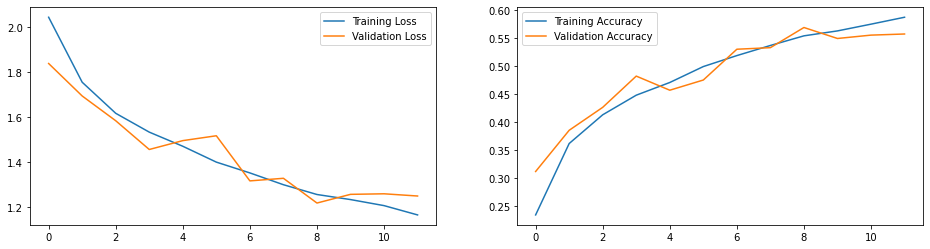

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred10= model_10.predict(x_test_norm)
pred10=np.argmax(pred10, axis=1)

In [ ]:
print_validation_report(y_test, pred10)

Classification Report
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      1000
           1       0.69      0.56      0.62      1000
           2       0.65      0.30      0.41      1000
           3       0.54      0.21      0.31      1000
           4       0.57      0.52      0.54      1000
           5       0.63      0.46      0.53      1000
           6       0.58      0.77      0.67      1000
           7       0.47      0.72      0.57      1000
           8       0.70      0.61      0.66      1000
           9       0.43      0.82      0.56      1000

    accuracy                           0.56     10000
   macro avg       0.59      0.56      0.55     10000
weighted avg       0.59      0.56      0.55     10000

Accuracy Score: 0.5634
Root Mean Square Error: 3.109839224140052


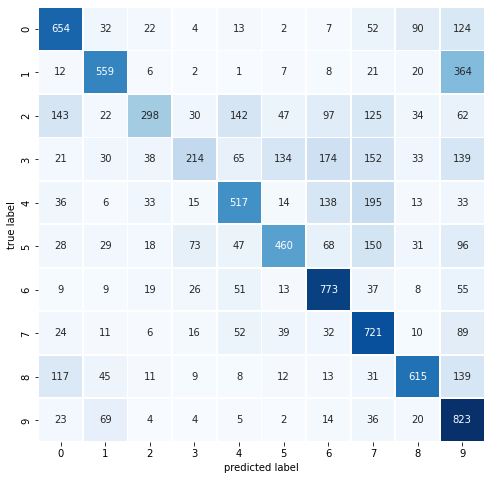

In [ ]:
plot_confusion_matrix(y_test,pred10)

#**Experiment 6 - GridSearch on other hyperparameters for improvement upon best CNN model from experiment 5**

https://towardsdatascience.com/deep-learning-with-cifar-10-image-classification-64ab92110d79


#**Result1**
Create a table with the accuracy and loss for train/test/validation & process time for ALL the models.

In [ ]:
score = [model_1_score, model_2_score, model_3_score, model_4_score, model_5_score, model_6_score, model_7_score, model_8_score, model_9_score, model_10_score]

In [ ]:
Perf_table = pd.DataFrame(score, index =['model1', 'model2', 'model3','model4','model5','model6','model7','model8','model9','model10'])

description = ['DNN-2 layer-no regularization',
               'DNN-3 layer-no regularization',
               'CNN-2 layer-no regularization',
               'CNN-3 layer-no regularization',
               'DNN-2 layer-with L2 regularization / Dropout / BatchNormalization',
               'DNN-3 layer-with L2 regularization / Dropout / BatchNormalization',
               'CNN-2 layer-with L2 regularization / Dropout / BatchNormalization',
               'CNN-3 layer-with L2 regularization / Dropout / BatchNormalization',
               'CNN-2 layer-Data Augmentation (rotate/flip)',
               'CNN-3 layer-Data Augmentation (rotate/flip)',
]

Perf_table.insert(0, 'Description', description)

PrintPerf_table

,Description,accuracy_train,accuracy_valid,accuracy_test,f1_test,recall_test,precision_test,train_time
model1,DNN-2 layer-no regularization,0.513000,0.4586,0.4744,0.461351,0.4744,0.486725,20.908893
model2,DNN-3 layer-no regularization,0.488000,0.4500,0.4622,0.449745,0.4622,0.476422,8.297839
model3,CNN-2 layer-no regularization,0.917267,0.7126,0.7104,0.708750,0.7104,0.718264,61.643661
model4,CNN-3 layer-no regularization,0.853200,0.7306,0.7289,0.726467,0.7289,0.732115,41.099482
model5,DNN-2 layer-with L2 regularization / Dropout /...,0.442578,0.4164,0.4345,0.430742,0.4345,0.444887,11.816478
model6,DNN-3 layer-with L2 regularization / Dropout /...,0.427933,0.3990,0.4163,0.398141,0.4163,0.432377,9.910189
model7,CNN-2 layer-with L2 regularization / Dropout /...,0.965511,0.7546,0.7529,0.751482,0.7529,0.759941,72.869413
model8,CNN-3 layer-with L2 regularization / Dropout /...,0.958822,0.8008,0.7988,0.796384,0.7988,0.800900,86.047304
model9,CNN-2 layer-Data Augmentation (rotate/flip),0.583667,0.5616,0.5680,0.548915,0.5680,0.569648,42.727110
model10,CNN-3 layer-Data Augmentation (rotate/flip),0.578022,0.5576,0.5634,0.549912,0.5634,0.589437,41.628106


#**Result2**


In [ ]:
%%shell
jupyter nbconvert --to html /content/gdrive/MyDrive/MSDS458/Liu_Assignment2_MSDS458_1.ipynb

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/MSDS458/Liu_Assignment2_MSDS458_1.ipynb to html
[NbConvertApp] Writing 2351190 bytes to /content/gdrive/MyDrive/MSDS458/Liu_Assignment2_MSDS458_1.html
